In [71]:
import numpy as np
import pandas as pd
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import transform
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import RandomChoice

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from PIL import Image

In [72]:
batch_size = 32
epochs_number = 200
patience = 3

In [73]:
#Create dataset
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [74]:
#Model
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier,self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
         
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        
        return output

In [75]:
transform_train = transforms.Compose([
        transforms.Resize((128, 128)), #Resize to 128x128
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((128, 128)), #Resize to 128x128
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = r'C:\Users\piotr\Desktop\data\train'
valid_folder = r'C:\Users\piotr\Desktop\data\valid'
test_folder = r'C:\Users\piotr\Desktop\data\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform_train)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [76]:
# Early stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = "Stopping training"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [78]:

num_epochs = epochs_number
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-04)

es = EarlyStopping(patience=patience)

epoch = 0
done = False
while epoch < num_epochs and not done:
    epoch += 1
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)  # Pobieranie prognoz
        running_corrects += (preds == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = running_corrects / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)  # Pobieranie prognoz
            running_corrects += (preds == labels).sum().item()
    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = running_corrects / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(
        f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Train acc: {train_accuracy:.4f}, Val acc: {val_accuracy:.4f}")

    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/200 - Train loss: 3.3089, Validation loss: 1.9747, Train acc: 0.1495, Val acc: 0.3660
Early Stopping: 0/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/200 - Train loss: 2.2209, Validation loss: 1.5216, Train acc: 0.3358, Val acc: 0.4981
Early Stopping: 0/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/200 - Train loss: 1.7337, Validation loss: 1.0406, Train acc: 0.4794, Val acc: 0.7019
Early Stopping: 0/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/200 - Train loss: 1.2759, Validation loss: 0.8663, Train acc: 0.6274, Val acc: 0.7321
Early Stopping: 0/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/200 - Train loss: 0.9114, Validation loss: 0.6647, Train acc: 0.7288, Val acc: 0.8226
Early Stopping: 0/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/200 - Train loss: 0.6840, Validation loss: 0.5320, Train acc: 0.7963, Val acc: 0.8453
Early Stopping: 0/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/200 - Train loss: 0.4799, Validation loss: 0.5504, Train acc: 0.8560, Val acc: 0.8415
Early Stopping: 1/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/200 - Train loss: 0.3469, Validation loss: 0.6209, Train acc: 0.8968, Val acc: 0.8604
Early Stopping: 2/3


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/200 - Train loss: 0.2708, Validation loss: 0.6185, Train acc: 0.9171, Val acc: 0.8717
Early Stopping: Stopping training


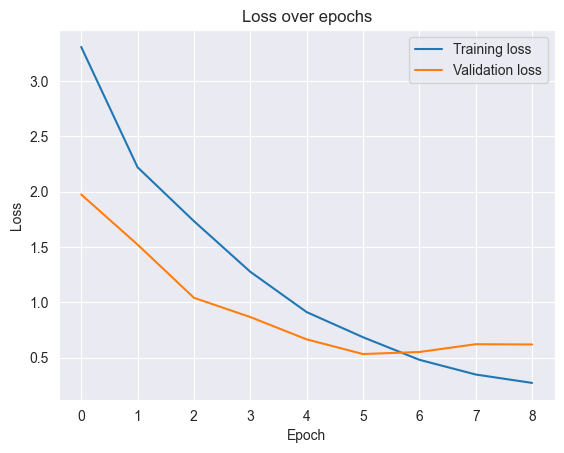

In [79]:
#Visualize Losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

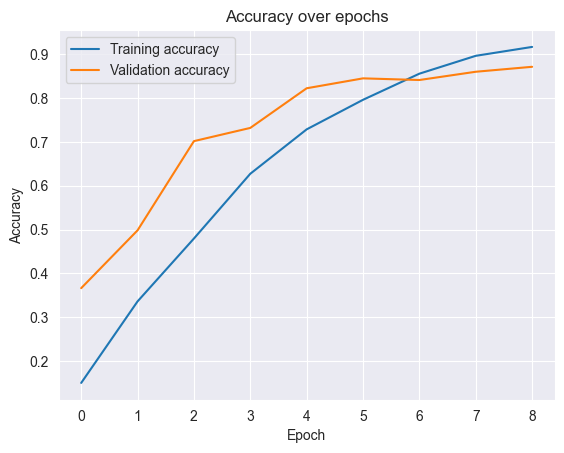

In [80]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [81]:
# Calculate the Accuracy of the Model using test data

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.53%


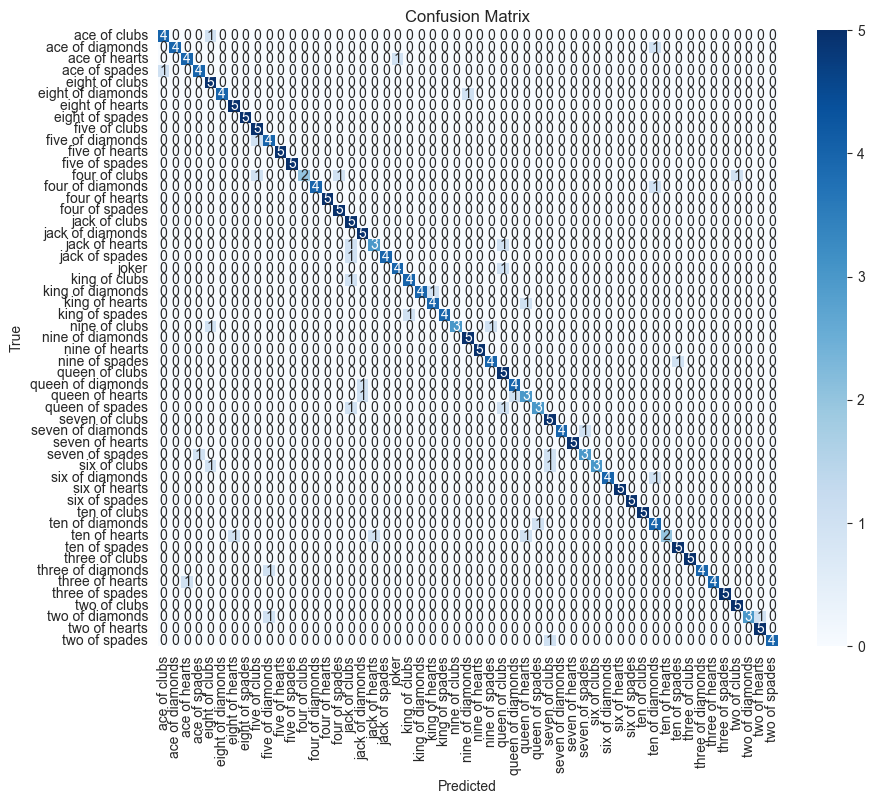

In [82]:
# Calculate predictions on test data
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [83]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

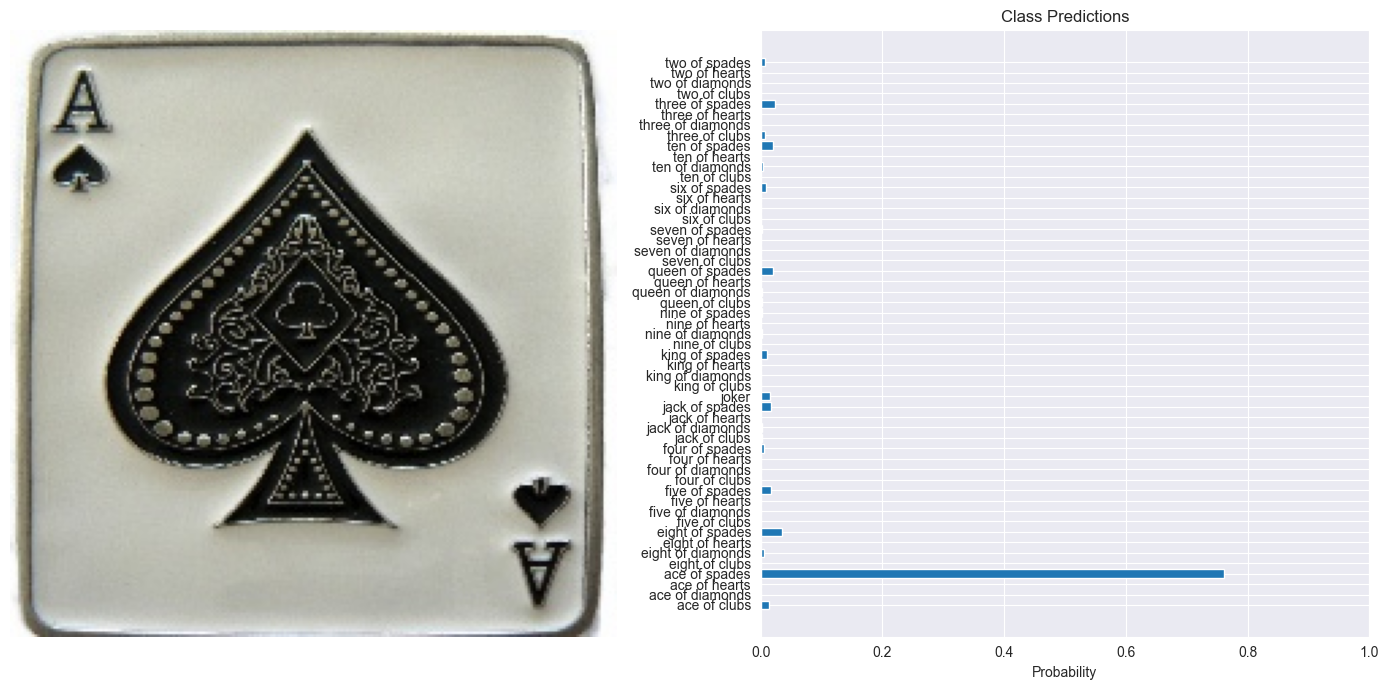

In [84]:
dataset = PlayingCardDataset(r'C:\Users\piotr\Desktop\data\train')
test_image = r'C:\Users\piotr\Desktop\data\test\ace of spades\2.jpg'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)


class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)